<a href="https://colab.research.google.com/github/guberney/Covid_Colombia/blob/master/CovidColombia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  **Análisis de datos sobre el coronavirus en Colombia. **
Con el presente código se quiere abrir la oportunidad para que puedan realizar gráficos y análisis particuales de diferentes lugares de Colombia. Se estará actualizando cada día.
---
Autor del código: @guberney

Universidad de Antioquia, Colombia

La base principal de información es tomada del Instituto Nacional de Salud. https://www.ins.gov.co/Noticias/Paginas/Coronavirus.aspx Al final encuentran un link: Download data . 

#Cargar librerias
Se cargan las liberías requerida para el código. El ecosistema principal de la programación es tydiverse de R. 

In [0]:
library(ggplot2) #Gramática de gráficos
library(tidyverse) #Ecosistema para manipulación de datos
install.packages("ggthemes")
library(ggthemes)
library(lubridate) #para el manejo de datos tipo fechas.

## Base de datos 
Cargar base de datos reportada por el Ministerio de salud de Colombia, la cual se encuentra alojada en este mismo repositorio [https://github.com/guberney/Covid_Colombia/tree/master/Covid_datos/SerieTiempo]

In [2]:
covidCol<-read_csv("https://raw.githubusercontent.com/guberney/Covid_Colombia/master/Covid_datos/SerieTiempo/casos_covid_19_Colombia.csv")
tail(covidCol, 5)

Parsed with column specification:
cols(
  `ID de caso` = col_double(),
  `Fecha de diagnóstico` = col_character(),
  `Ciudad de ubicación` = col_character(),
  `Departamento o Distrito` = col_character(),
  `Atención**` = col_character(),
  Edad = col_double(),
  Sexo = col_character(),
  `Tipo*` = col_character(),
  `País de procedencia` = col_character()
)



ID de caso,Fecha de diagnóstico,Ciudad de ubicación,Departamento o Distrito,Atención**,Edad,Sexo,Tipo*,País de procedencia
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1481,05/04/2020,Bogotá,Bogotá D.C.,Casa,49,F,En estudio,Colombia
1482,05/04/2020,Bogotá,Bogotá D.C.,Casa,19,M,En estudio,Colombia
1483,05/04/2020,Bogotá,Bogotá D.C.,Hospital,97,F,En estudio,Colombia
1484,05/04/2020,Bogotá,Bogotá D.C.,Casa,75,M,En estudio,Colombia
1485,05/04/2020,Bogotá,Bogotá D.C.,Casa,56,F,En estudio,Colombia


#Variables de la base de datos.
Ajustar las variables para mejorar el procesamiento de los datos. Se convierte la fecha a una variable tipo fecha y se crea una nueva variable EdadClases para realizar análisis por grupos poblacionales. 


In [3]:
str(covidCol) #muestra la estructura de los datos y el tipo de variables. 
covidCol<-covidCol %>% as_tibble() #convertir los datos a una forma mejorada de dataframe
sapply(covidCol, class) #ver la clase de cada columna de la base de datos##
covidCol<-covidCol%>%mutate(`Fecha de diagnóstico`=dmy(covidCol$`Fecha de diagnóstico`))
covidCol<-covidCol%>% mutate(EdadClases = cut(Edad, breaks = c(0,9,19,29,39,49,59,69,79,88), 
                                               labels = c("0-9","10-19","20-29","30-39","40-49","50-59","60-69", "70-79","80-+")))

Classes ‘spec_tbl_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	1485 obs. of  9 variables:
 $ ID de caso             : num  1 2 3 4 5 6 7 8 9 10 ...
 $ Fecha de diagnóstico   : chr  "06/03/2020" "09/03/2020" "09/03/2020" "11/03/2020" ...
 $ Ciudad de ubicación    : chr  "Bogotá" "Buga" "Medellín" "Medellín" ...
 $ Departamento o Distrito: chr  "Bogotá D.C." "Valle del Cauca" "Antioquia" "Antioquia" ...
 $ Atención**             : chr  "Recuperado" "Recuperado" "Recuperado" "Recuperado" ...
 $ Edad                   : num  19 34 50 55 25 27 85 22 28 36 ...
 $ Sexo                   : chr  "F" "M" "F" "M" ...
 $ Tipo*                  : chr  "Importado" "Importado" "Importado" "Relacionado" ...
 $ País de procedencia    : chr  "Italia" "España" "España" "Colombia" ...
 - attr(*, "spec")=
  .. cols(
  ..   `ID de caso` = col_double(),
  ..   `Fecha de diagnóstico` = col_character(),
  ..   `Ciudad de ubicación` = col_character(),
  ..   `Departamento o Distrito` = col_character(),
  ..   `Atenci

ID de caso    Fecha de diagnóstico     Ciudad de ubicación 
              "numeric"             "character"             "character" 
Departamento o Distrito              Atención**                    Edad 
            "character"             "character"               "numeric" 
                   Sexo                   Tipo*     País de procedencia 
            "character"             "character"             "character"

In [4]:
str(covidCol)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1485 obs. of  10 variables:
 $ ID de caso             : num  1 2 3 4 5 6 7 8 9 10 ...
 $ Fecha de diagnóstico   : Date, format: "2020-03-06" "2020-03-09" ...
 $ Ciudad de ubicación    : chr  "Bogotá" "Buga" "Medellín" "Medellín" ...
 $ Departamento o Distrito: chr  "Bogotá D.C." "Valle del Cauca" "Antioquia" "Antioquia" ...
 $ Atención**             : chr  "Recuperado" "Recuperado" "Recuperado" "Recuperado" ...
 $ Edad                   : num  19 34 50 55 25 27 85 22 28 36 ...
 $ Sexo                   : chr  "F" "M" "F" "M" ...
 $ Tipo*                  : chr  "Importado" "Importado" "Importado" "Relacionado" ...
 $ País de procedencia    : chr  "Italia" "España" "España" "Colombia" ...
 $ EdadClases             : Factor w/ 9 levels "0-9","10-19",..: 2 4 6 6 3 3 9 3 3 4 ...


#**Casos reportados diarios**
Gráfico de barras de los datos reportados diarios por INS para todo el país. Primero se hace una tabala agrupando las fecha y creando dos variables resumen, n para datos diarios, "Acumulados" para ver los casos acumulados por días. 

In [5]:
casos<- covidCol%>% 
          group_by(`Fecha de diagnóstico`) %>% 
          summarise (n = n())%>% 
          mutate(Acumulados = cumsum(n))
head(casos, 5)
  

Fecha de diagnóstico,n,Acumulados
<date>,<int>,<int>
2020-03-06,1,1
2020-03-09,2,3
2020-03-11,6,9
2020-03-12,4,13
2020-03-13,3,16


#Casos reportados con Covid-19 en Colombia
Gráfico de casos reportados diarios y acumulados. Se puede ajustar par ver los acumulados o los diarios (n) 

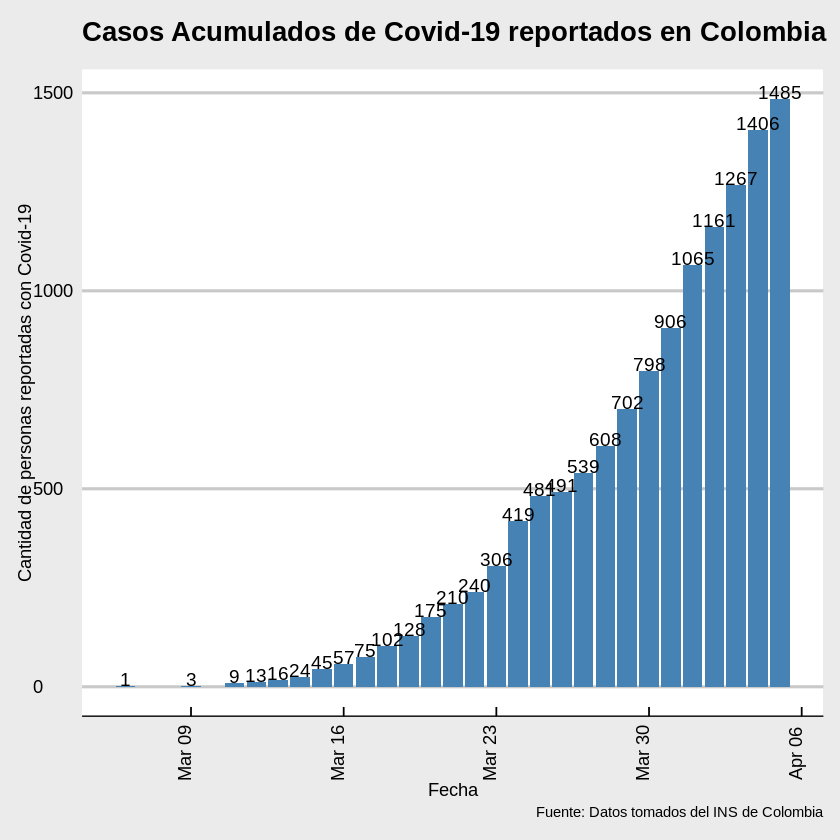

In [17]:
 CasosCol<-casos%>%
 ggplot (aes(x = `Fecha de diagnóstico`, y =  `Acumulados`)) + #Par ver el gráfico reportes diarios, cambiar `Acumulados` por n
  geom_bar(stat = "identity", fill= "steelblue" )+ #Pueden cambiar el color del gráfico por ejemplo "skyblue", "red"... entre otros. 
  labs(title = "Casos Acumulados de Covid-19 reportados en Colombia", subtitle = " ", #las etiquetas del gráfico.
       x = "Fecha", y = "Cantidad de personas reportadas con Covid-19", caption = "Fuente: Datos tomados del INS de Colombia")+
  geom_text(aes(label = `Acumulados`), vjust = 0, color="black", size=4.0, #ajustar el texto del gráfico, si van a cambiar a diarios, recuerden cambiar n por `Acumulados` 
            position = position_dodge(width=0.9))+
   theme_economist_white()+ #tema del gráfico, formato preestablecido
  theme(axis.text.x = element_text(angle = 90)) #rotar los labels de los ejes
CasosCol

In [7]:
86/1161


[1] 0.07407407

Para hacer gráficos por ciudades o departamentos, se puede repetir el gráfico anterior pero con filtros según el lugar de interes. El ejemplo se muestra con Medellín pero lo pueden cambiar para ver cualquier ciudad de interés. 

In [8]:
unique(covidCol$`Ciudad de ubicación`)

[1] "Bogotá"                 "Buga"                   "Medellín"              
  [4] "Itagüí"                 "Cartagena"              "Neiva"                 
  [7] "Palmira"                "Villavicencio"          "Rionegro"              
 [10] "Cali"                   "Dosquebradas"           "Cúcuta"                
 [13] "Manizales"              "Subachoque"             "Soacha"                
 [16] "Barranquilla"           "Bucaramanga"            "Armenia"               
 [19] "Pereira"                "Cajicá"                 "Ibagué"                
 [22] "Popayán"                "Viterbo"                "Anapoima"              
 [25] "Envigado"               "Santa Marta"            "Chía"                  
 [28] "Madrid"                 "Villa del Rosario"      "Guarne"                
 [31] "Bello"                  "Calarcá"                "Valledupar"            
 [34] "La Dorada"              "Chinchiná"              "BUCARAMANGA"           
 [37] "San Andrés"             "Yumbo"                  "Yopal"                 
 [40] "Guatapé"                "Barbosa"                "Cota"                  
 [43] "Sabaneta"               "Villamaría"             "Trujillo"              
 [46] "Pacho"                  "El Retiro"              "Apartadó"              
 [49] "Ipiales"                "Mosquera"               "La Unión"              
 [52] "Cartago"                "Fusagasugá"             "La Calera"             
 [55] "Villeta"                "Palermo"                "San Pedro"             
 [58] "Darién"                 "Funza"                  "Tuluá"                 
 [61] "Soledad"                "El Dovio"               "Santana"               
 [64] "Frontino"               "Tunja"                  "Tocancipá"             
 [67] "Puerto Colombia"        "Sahagún"                "Pasto"                 
 [70] "Polonuevo"              "Villapinzón"            "Montebello"            
 [73] "Santa Rosa de Osos"     "Turbaco"                "Sincelejo"             
 [76] "Floridablanca"          "Lorica"                 "Oicatá"                
 [79] "Arjona"                 "Sopó"                   "Tumaco"                
 [82] "Riohacha"               "Zipaquirá"              "Puerto Santander"      
 [85] "Toguí"                  "Montenegro"             "Cumbal"                
 [88] "Ulloa"                  "Santander de Quilichao" "CALI"                  
 [91] "cali"                   "Filandia"               "Circasia"              
 [94] "Anserma"                "Don Matías"             "San Antonio de Prado"  
 [97] "Choachí"                "Cocorná"                "Monteria"              
[100] "La Estrella"            "Guacarí"                "Tenjo"                 
[103] "Buenaventura"           "Acacias"

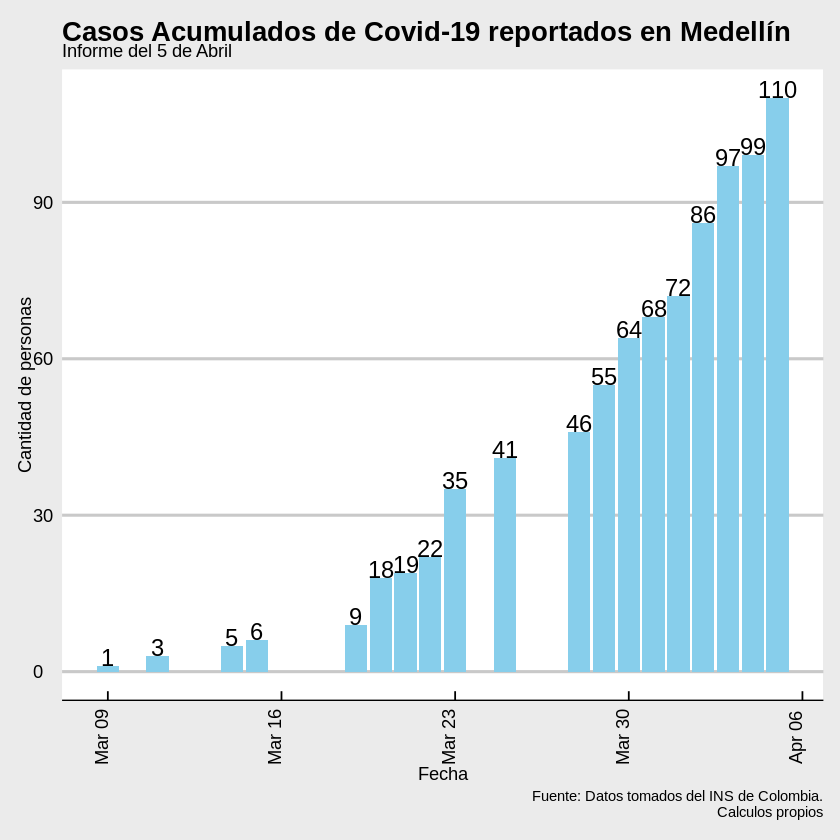

In [9]:
covidCol%>% filter(`Ciudad de ubicación`=="Medellín")%>% #Para hacer algúna ciudad específica, escribir el nombre entre comillas. Usa el resultado anterior para ver la ciudad
          group_by(`Fecha de diagnóstico`) %>% 
          summarise (n=n())%>% 
          mutate(Acumulados = cumsum(n))%>%
  
  ggplot (aes(x = `Fecha de diagnóstico`, y = Acumulados)) +  #se puede cambiar par ver un gráfico acumulado. 
  geom_bar(stat = "identity", fill= "skyblue" )+
  labs(title = "Casos Acumulados de Covid-19 reportados en Medellín", subtitle = "Informe del 5 de Abril", #Recuerda cambiar el título según la ciudad que quieras ver.
       x = "Fecha", y = "Cantidad de personas", caption = "Fuente: Datos tomados del INS de Colombia.\nCalculos propios")+
  geom_text(aes(label = Acumulados ), vjust = 0, color="black", size=5.0,
            position = position_dodge(width=0.9))+
  theme_economist_white()+ 
  theme(axis.text.x = element_text(angle = 90)) #rotar los labels de los ejes

#Municipios con más de 30 casos de Covid_19 en Colombia
A continuación se crea un ciclo para ver los datos de los municipos que tienen más de 30 casos reportados. 

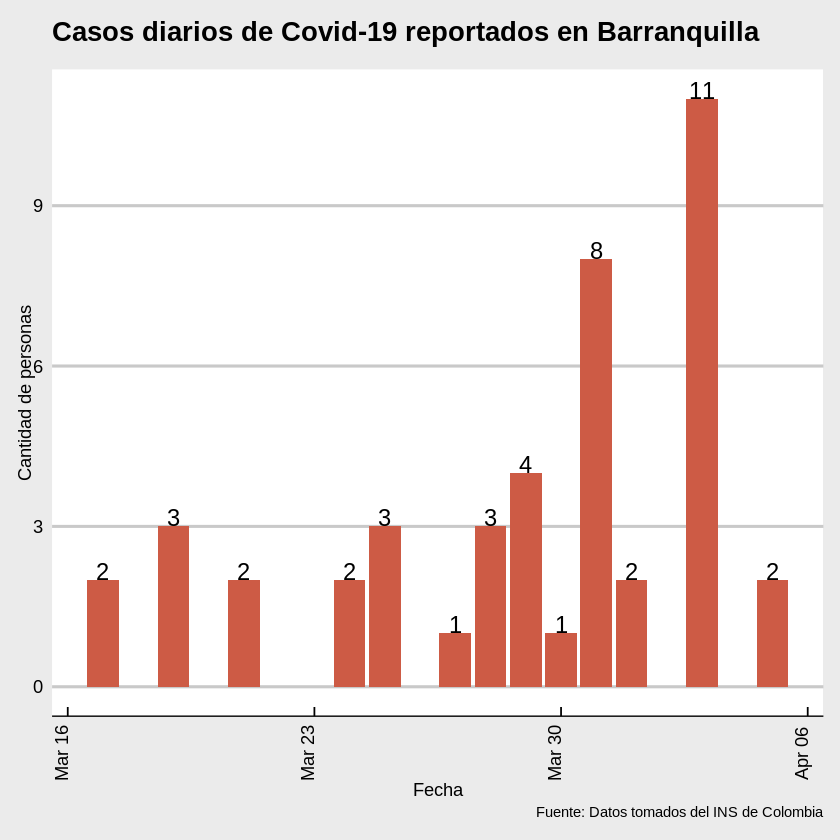

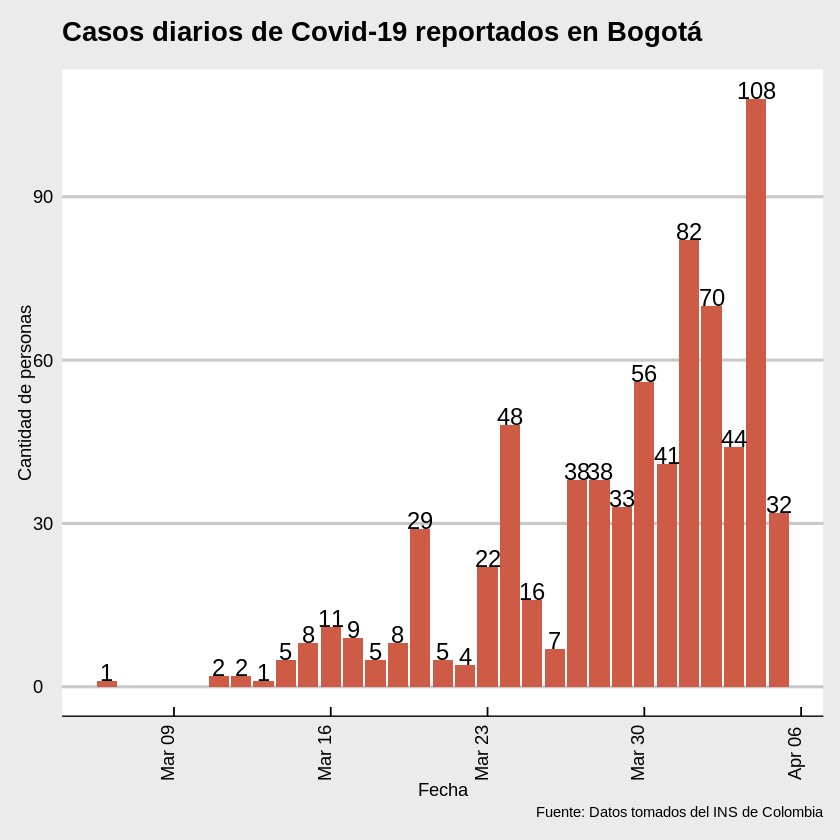

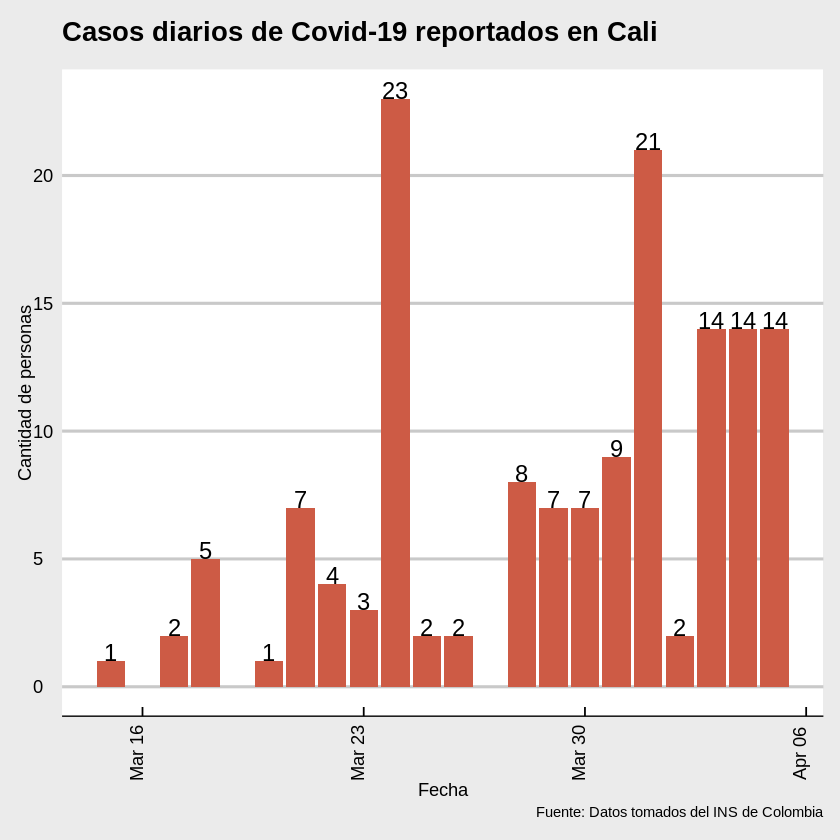

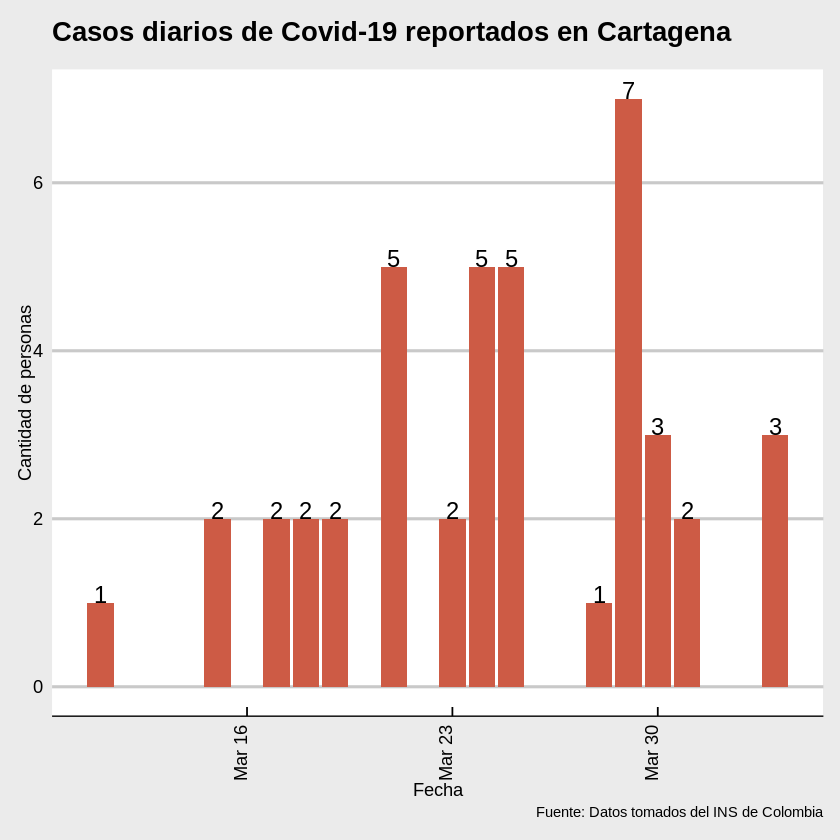

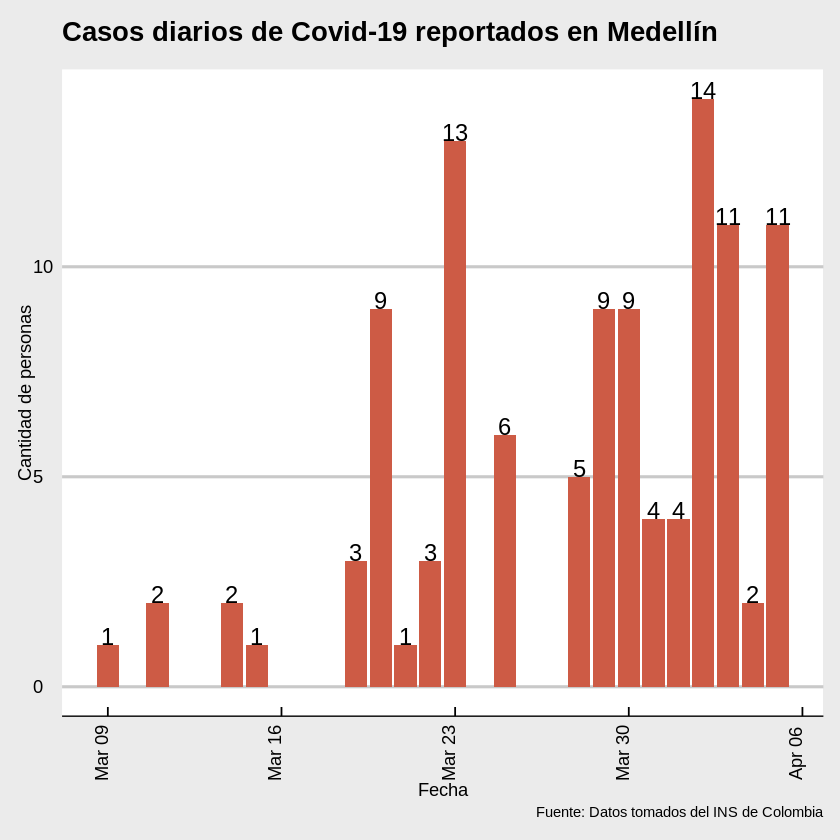

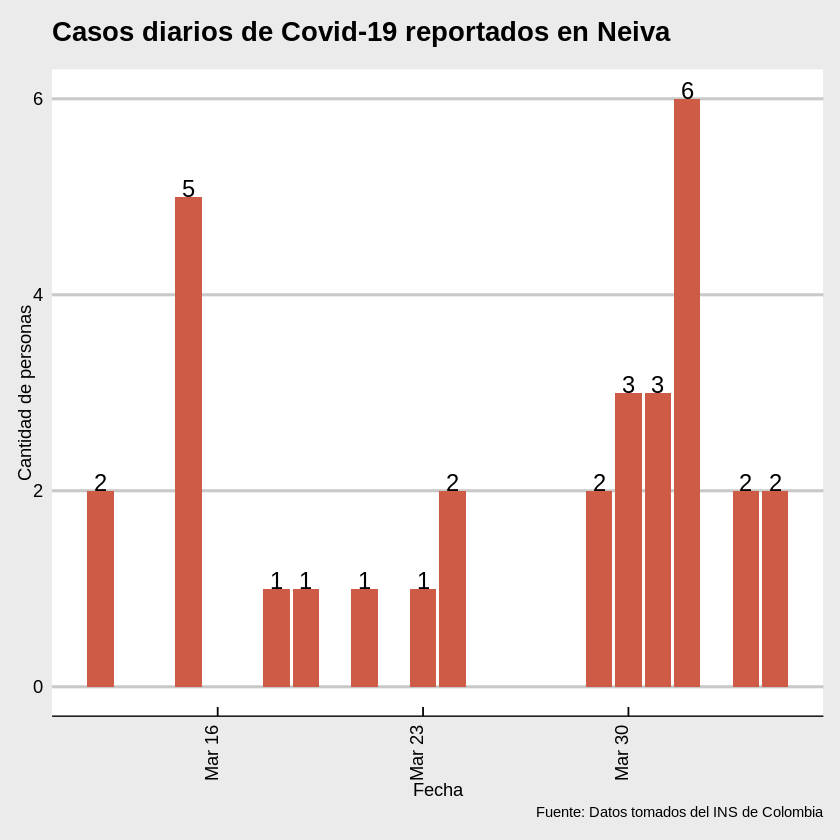

In [10]:
tab <- table(covidCol$`Ciudad de ubicación`)
municipio <- names(tab[tab>30])

for(mun in municipio){
  title <- paste("Casos diarios de Covid-19 reportados en",mun)
  
  graficoCasos <- covidCol%>% filter(`Ciudad de ubicación`==mun)%>%
          group_by(`Fecha de diagnóstico`) %>% 
          summarise (n=n())%>% 
          mutate(Acumulados = cumsum(n))%>%  
  ggplot (aes(x = `Fecha de diagnóstico`, y = n)) +  #se puede cambiar par ver un gráfico Acumulados. 
  geom_bar(stat = "identity", fill= "coral3" )+
  labs(title = title, subtitle = " ", #Recuerda cambiar el título según la ciudad que quieras ver.
       x = "Fecha", y = "Cantidad de personas", caption = "Fuente: Datos tomados del INS de Colombia")+
  geom_text(aes(label = n ), vjust = 0, color="black", size=5.0,
            position = position_dodge(width=0.9))+
  theme_economist_white()+ 
  theme(axis.text.x = element_text(angle = 90)) #rotar los labels de los ejes

  print(graficoCasos)
}


#Casos confirmados por ciudades
Un gráfico comparativo de casos totales en las ciudades de colombia. Se filtran las ciudades que tienen más de un caso. El gráfico se puede hacer con los departamentos, solo se aplica el filtro de `Departamento` donde se encuentra la frase `Ciudad de Ubicación`. 

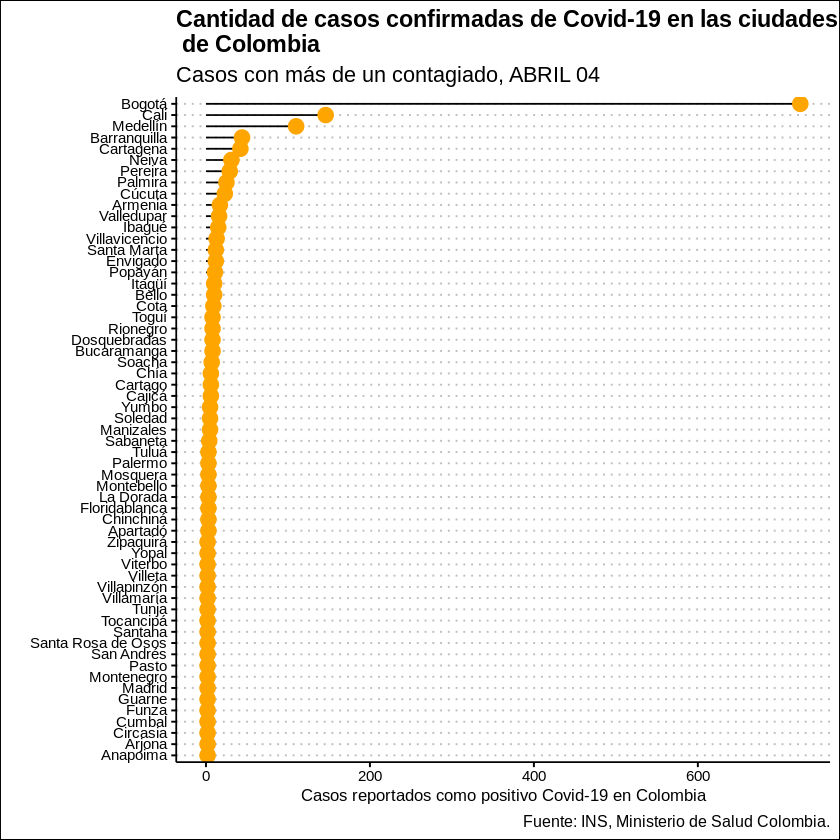

In [11]:
CasosCiudades <- covidCol %>% 
  group_by(`Ciudad de ubicación`) %>%
  summarise (n=n())%>%
  arrange(-n)
CasosCiudades %>% filter(n>1)%>%
  ggplot(aes(x= reorder(`Ciudad de ubicación`, n), y=n))+
  geom_segment( aes(xend=`Ciudad de ubicación`, yend=0)) +
  geom_point( size=4, color="orange") +
  labs(title = "Cantidad de casos confirmadas de Covid-19 en las ciudades\n de Colombia", 
        subtitle = "Casos con más de un contagiado, ABRIL 04",
       x = " ", y = "Casos reportados como positivo Covid-19 en Colombia", caption = "Fuente: INS, Ministerio de Salud Colombia.")+
  coord_flip() +
  theme_clean()

#**Pirámide de población contagiada**
Se crea un archivo con nombre pyramid y se multiplica por menos 1 los datos para la categoría masculina M, para invertir las barras. Luego se realiza el ggplot. Al final de código se puede  habilitar la función facet_wrap() que permite ver gráficos por cada uno de los departamentos.

Warning message:
“Factor `EdadClases` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `EdadClases` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `EdadClases` contains implicit NA, consider using `forcats::fct_explicit_na`”


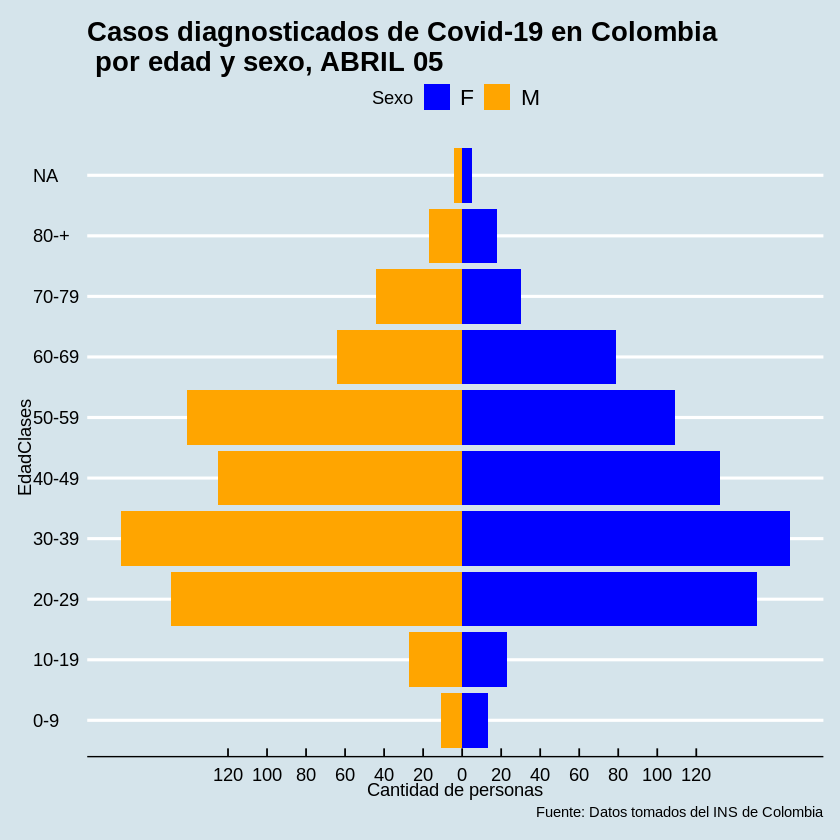

In [12]:
pyramid<-covidCol%>%group_by(EdadClases, Sexo, `Departamento o Distrito`)%>%summarise(n=n())
pyramid$n <- ifelse(pyramid$Sexo == "M", -1*pyramid$n, pyramid$n)

ggplot(pyramid, aes(x = EdadClases, y = n, fill = Sexo)) + 
  geom_bar(data = subset(pyramid, Sexo == "F"), stat = "identity") +
  geom_bar(data = subset(pyramid, Sexo == "M"), stat = "identity")+
  coord_flip()+
  scale_y_continuous(breaks=seq(-120,120,20),labels=abs(seq(-120,120,20)))+  #define los límites de la cantidad de personas del gráfico 
  labs(title="Casos diagnosticados de Covid-19 en Colombia\n por edad y sexo, ABRIL 05", y="Cantidad de personas", caption= "Fuente: Datos tomados del INS de Colombia")+
  scale_fill_manual("Sexo", values = c("F" = "blue", "M" = "orange"))+
  theme_economist() 
 # facet_wrap(~`Departamento o Distrito`) #Para ver los resultado por departamento, solo deber remover el # que antecede la función facet_wrap()

#Casos según la atención
Es un gráfico que permite ver dónde se encuentra el paciente. Incluye la población que ha fallecido.  

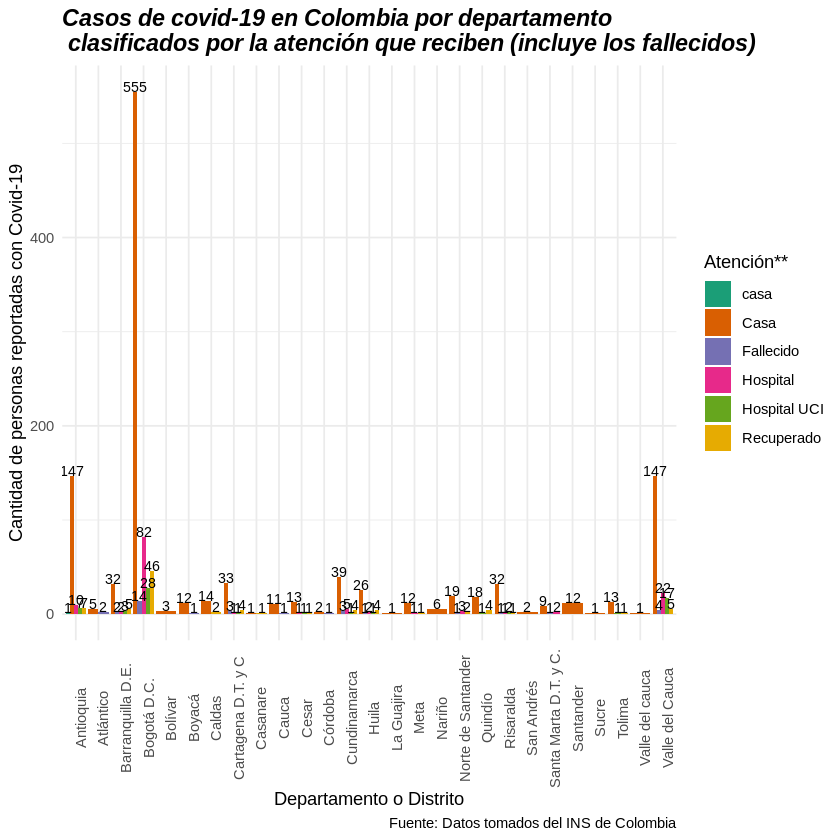

In [13]:
covidCol%>%
  group_by(`Atención**`, `Departamento o Distrito`) %>% 
  summarise (n = n())%>%
   
ggplot(aes(x=`Departamento o Distrito`, y= n, fill=`Atención**`))+
  geom_bar(stat = "identity", position = position_dodge())+
  geom_text(aes(x = `Departamento o Distrito`, y = n, label = paste0("",n,"")),
            size=3, vjust = 0, position = position_dodge(width=0.9))+
  scale_fill_brewer(palette="Dark2")+
  ggtitle("Casos de covid-19 en Colombia por departamento\n clasificados por la atención que reciben (incluye los fallecidos)")+
  labs(y = "Cantidad de personas reportadas con Covid-19", caption = "Fuente: Datos tomados del INS de Colombia")+
  theme_minimal()+
  theme (plot.title = element_text(color="black", size=14, face="bold.italic"))+
  theme(axis.text.x = element_text(angle = 90)) #rotar los labels de los ejes
  # annotate ("text", label = "1161 casos confirmados en\n Colombia, 02 Marzo", x = "Huila", y = 300, size = 6, colour = "blue")

#Gráfico de población fallecida por departamentos.


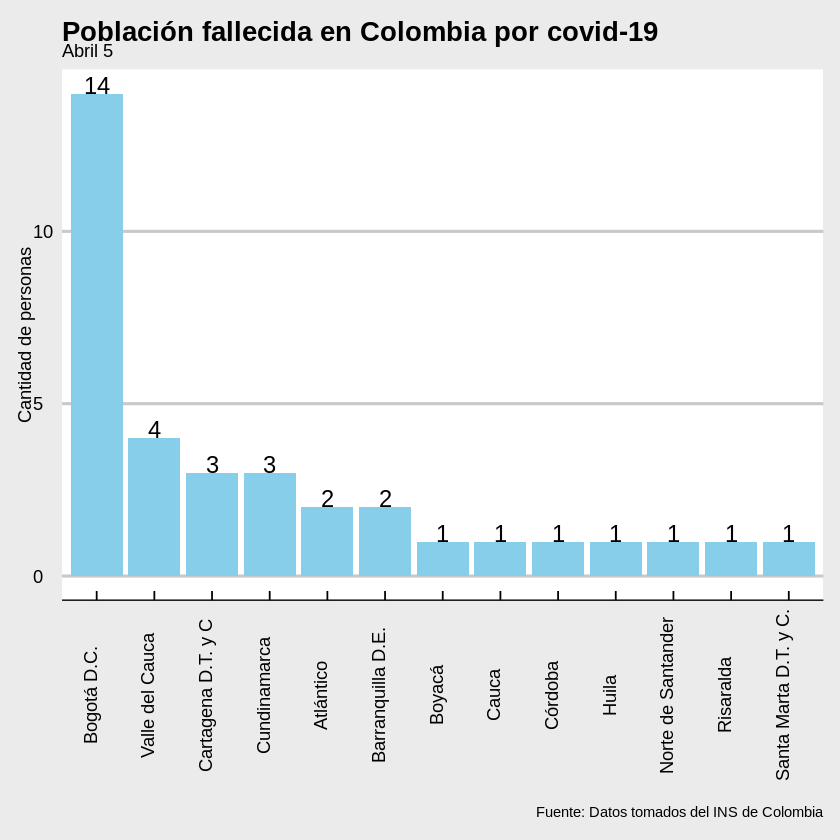

In [14]:
covidCol%>%group_by(`Departamento o Distrito`,`Atención**`)%>%summarise(n=n())%>%filter(`Atención**`=="Fallecido")%>%
ggplot(aes(x=reorder(`Departamento o Distrito`, -n), y=n))+
geom_bar(stat = "identity", fill= "skyblue")+
labs(title="Población fallecida en Colombia por covid-19", x=" ", y="Cantidad de personas", 
      caption = "Fuente: Datos tomados del INS de Colombia", subtitle = "Abril 5")+
geom_text(aes(x = `Departamento o Distrito`, y = n, label = paste0("",n,"")), 
            size=5, vjust = 0, position = position_dodge(width = 0.9))+            
theme_economist_white()+
theme(axis.text.x = element_text(angle = 90))

#Fallecios por edad y departamento
No se puede gráficar una persona que no tiene edad en la base de datos del INS. 

Warning message:
“Factor `EdadClases` contains implicit NA, consider using `forcats::fct_explicit_na`”


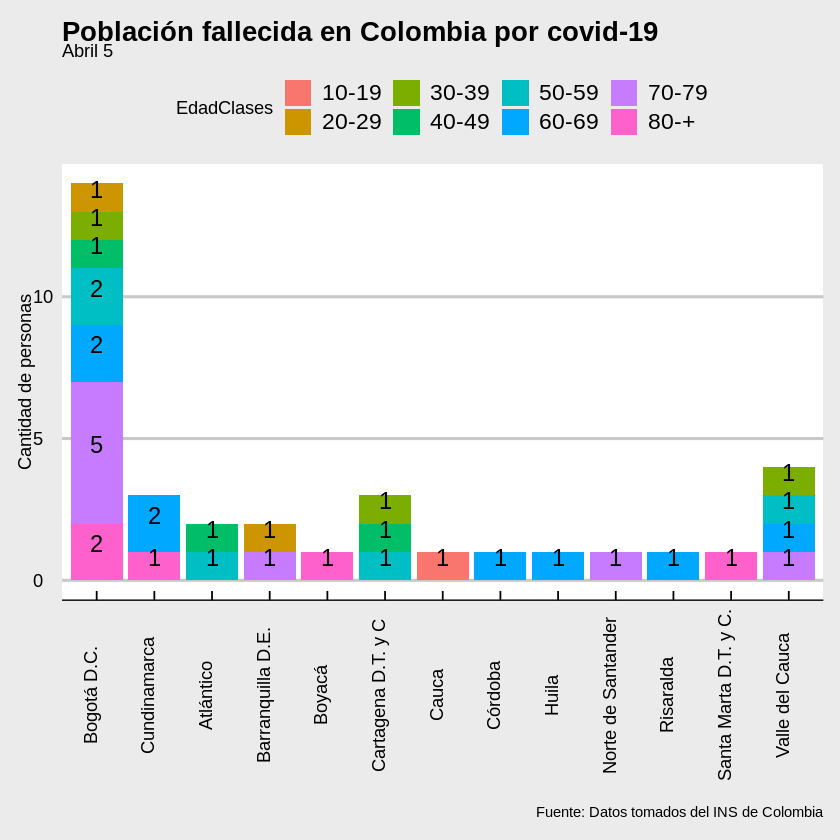

In [15]:
covidCol%>%group_by(EdadClases, `Departamento o Distrito`,`Atención**`)%>%summarise(n=n())%>%filter(`Atención**`=="Fallecido")%>%
ggplot(aes(x=reorder(`Departamento o Distrito`, -n), y=n, fill =EdadClases ))+
geom_bar(stat = "identity")+
labs(title="Población fallecida en Colombia por covid-19", x=" ", y="Cantidad de personas", 
      caption = "Fuente: Datos tomados del INS de Colombia", subtitle = "Abril 5")+
geom_text(aes(x = `Departamento o Distrito`, y = n, label = paste0("",n,"")), 
            size=5, vjust = 0, position = position_stack(vjust = .5))+            
theme_economist_white()+
theme(axis.text.x = element_text(angle = 90))

##Casos acumulados en Casa o Hospital
Se hace una recodificación de la variable Atención para agrupar los casos que son atendidos en Casa, Hospital y Hospital UCI. Así, se toman los datos en esas tres categorías. El gráfico excluye Bogotá porque no permite ver la tendencia de las otras ciudades; si quieren ver a Bogotá, miren el código y usen la base indicada para el filtro, a saber grapAcum, en el código se comenta. 

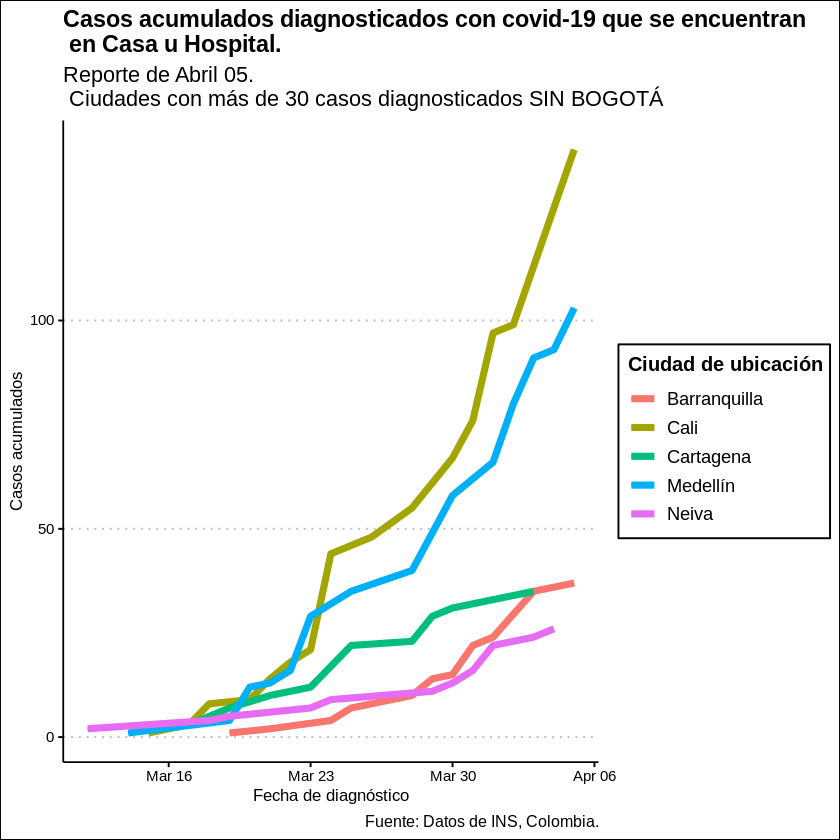

In [19]:
grapAcum <-covidCol%>%
  mutate(TipoAgrup = fct_collapse(`Atención**`,
                                  Casa.Hospital = c("Casa", "Hospital", "Hospital UCI"),
                                  Recuperado = "Recuperado"),
                                  Fallecido = "Fallecido")%>%
  
  group_by(`Ciudad de ubicación`,TipoAgrup,`Fecha de diagnóstico`) %>% 
  summarise (n = n())%>% 
  mutate(Acumulados = cumsum(n))%>%filter(`Ciudad de ubicación` %in% municipio)
  
d<-grapAcum%>%
filter(`Ciudad de ubicación` != "Bogotá") #Para quitar a Bogotá

d%>% filter(TipoAgrup=="Casa.Hospital")%>%  #Para que cargue Bogotá, cambiar d por grapAcum
  ggplot(aes(`Fecha de diagnóstico`, Acumulados, colour=`Ciudad de ubicación`)) +
  geom_line()+
  geom_path(size = 2)+
  labs(title="Casos acumulados diagnosticados con covid-19 que se encuentran\n en Casa u Hospital.",
       subtitle = "Reporte de Abril 05.\n Ciudades con más de 30 casos diagnosticados SIN BOGOTÁ",
       x= "Fecha de diagnóstico", y= "Casos acumulados", caption = "Fuente: Datos de INS, Colombia.")+
  theme_clean()